In [38]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_difference

# Load the data
file_path = r"C:\Users\olasu\Downloads\germandata.csv"
data = pd.read_csv(file_path)

class_distribution = data['credit'].value_counts()
print(class_distribution)

credit
1    700
2    300
Name: count, dtype: int64


In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
combined_categories = data['sex'] + "_" + data['Age_Metric'] 
# Apply one-hot encoding to these combined categories
combined_one_hot_encoded = pd.get_dummies(combined_categories)
combined_one_hot_encoded.columns = combined_one_hot_encoded.columns.str.lower()


new_data = data.join(combined_one_hot_encoded)
new_data = new_data.drop(['sex', 'Age_Metric'], axis = 1)

categorical_features = new_data.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    new_data[col] = new_data[col].fillna('missing')
    new_data[col] = le.fit_transform(new_data[col])
#print(new_data)

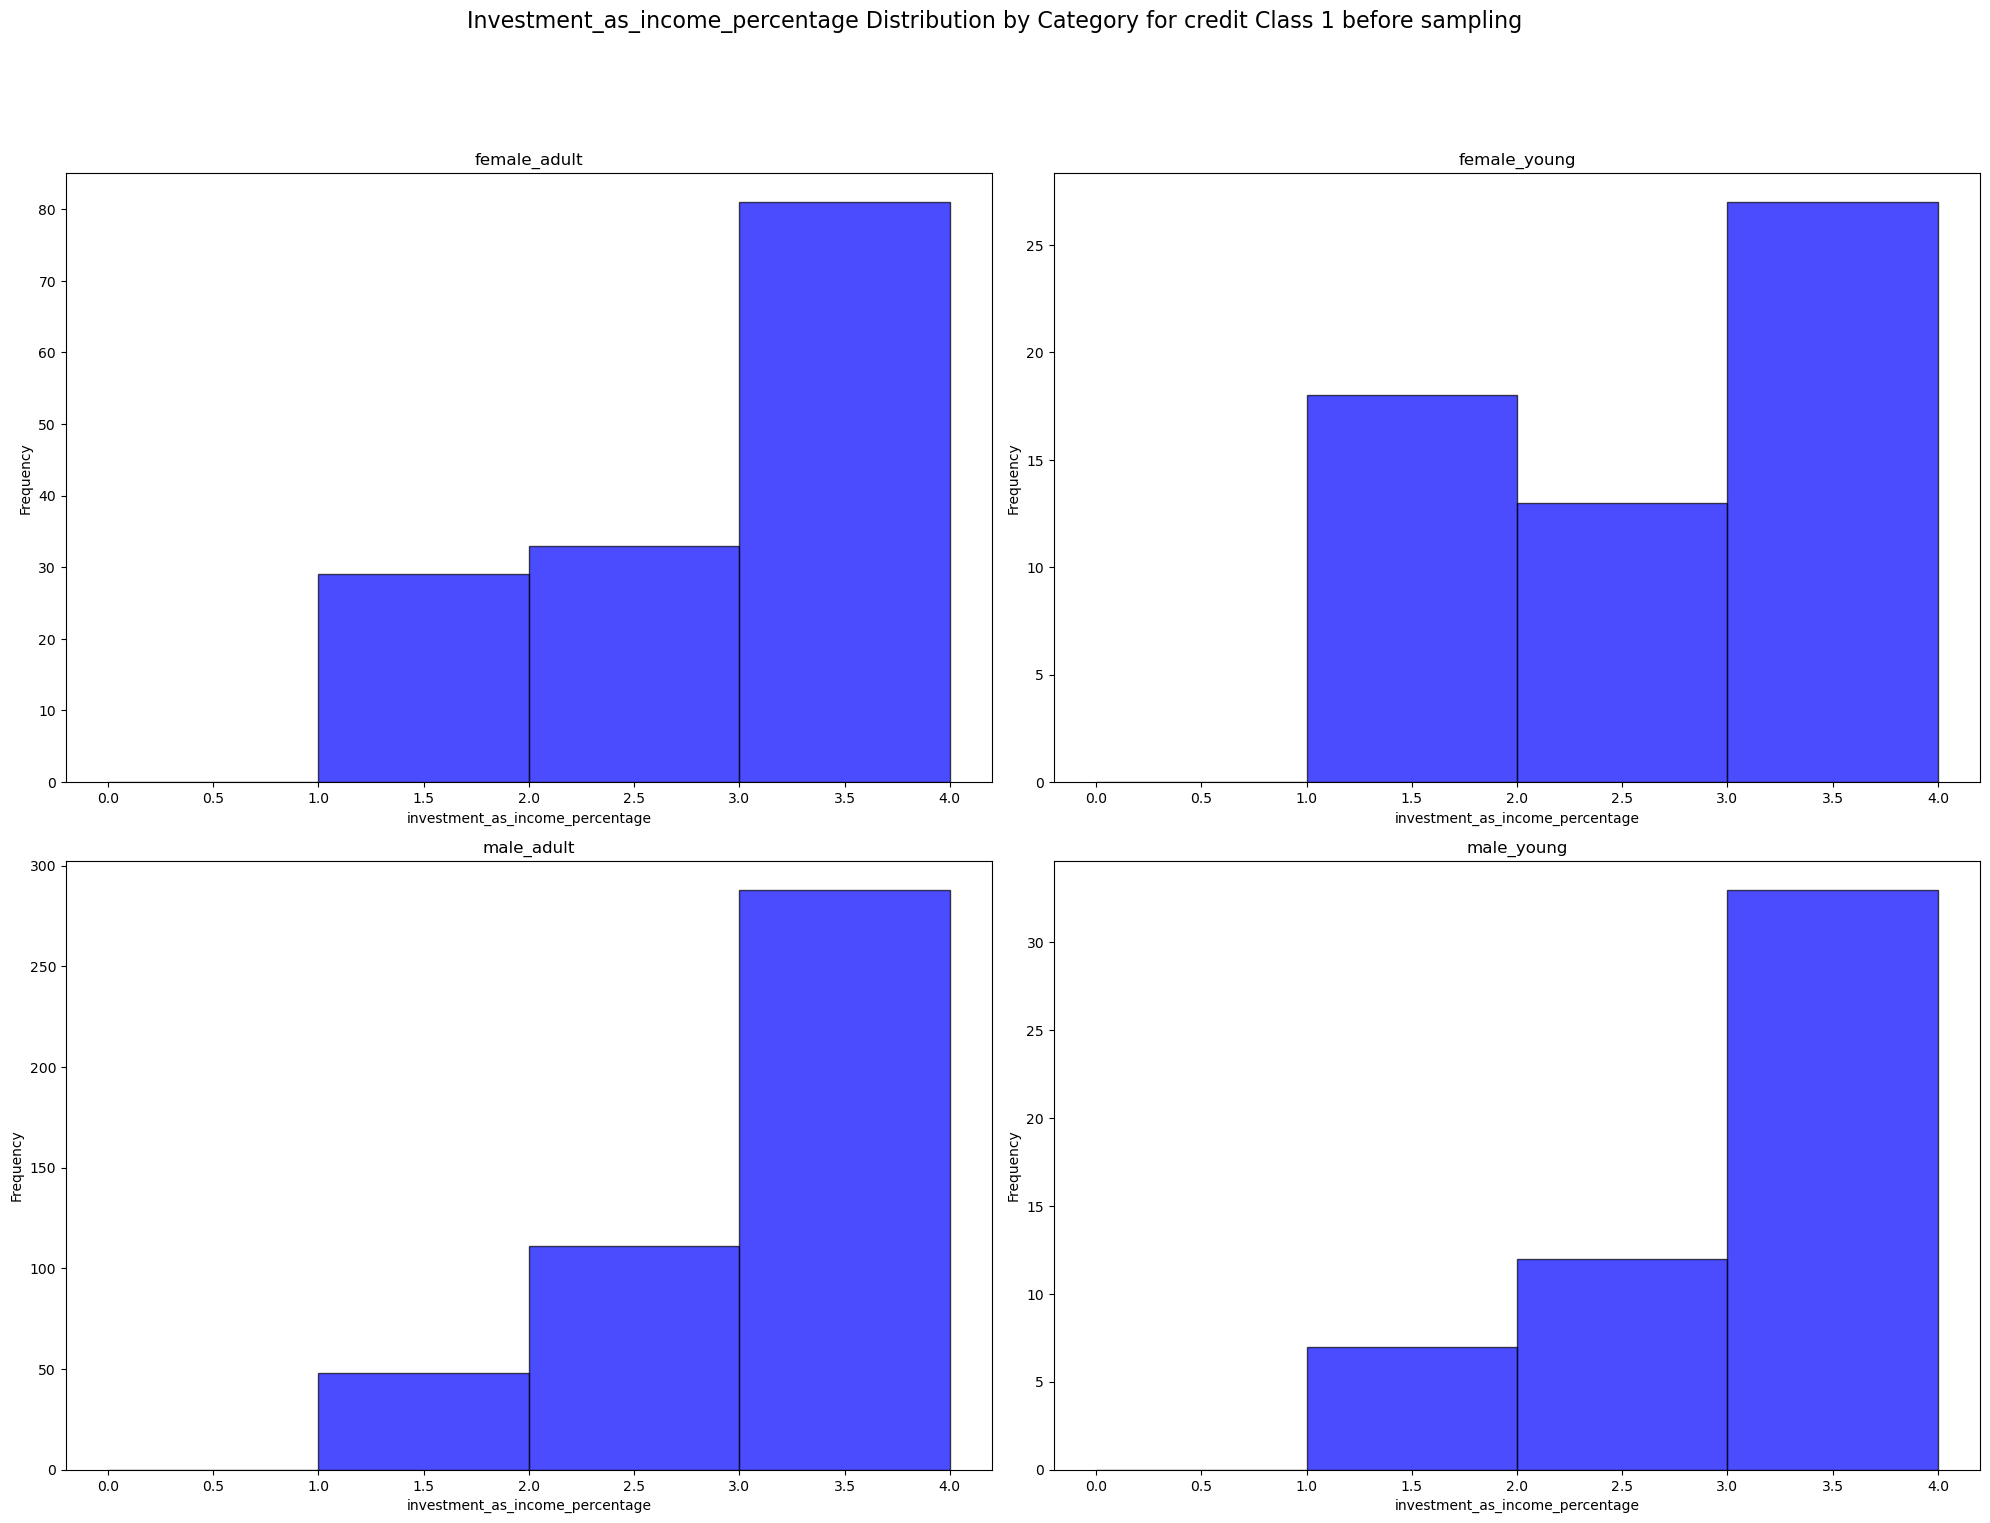

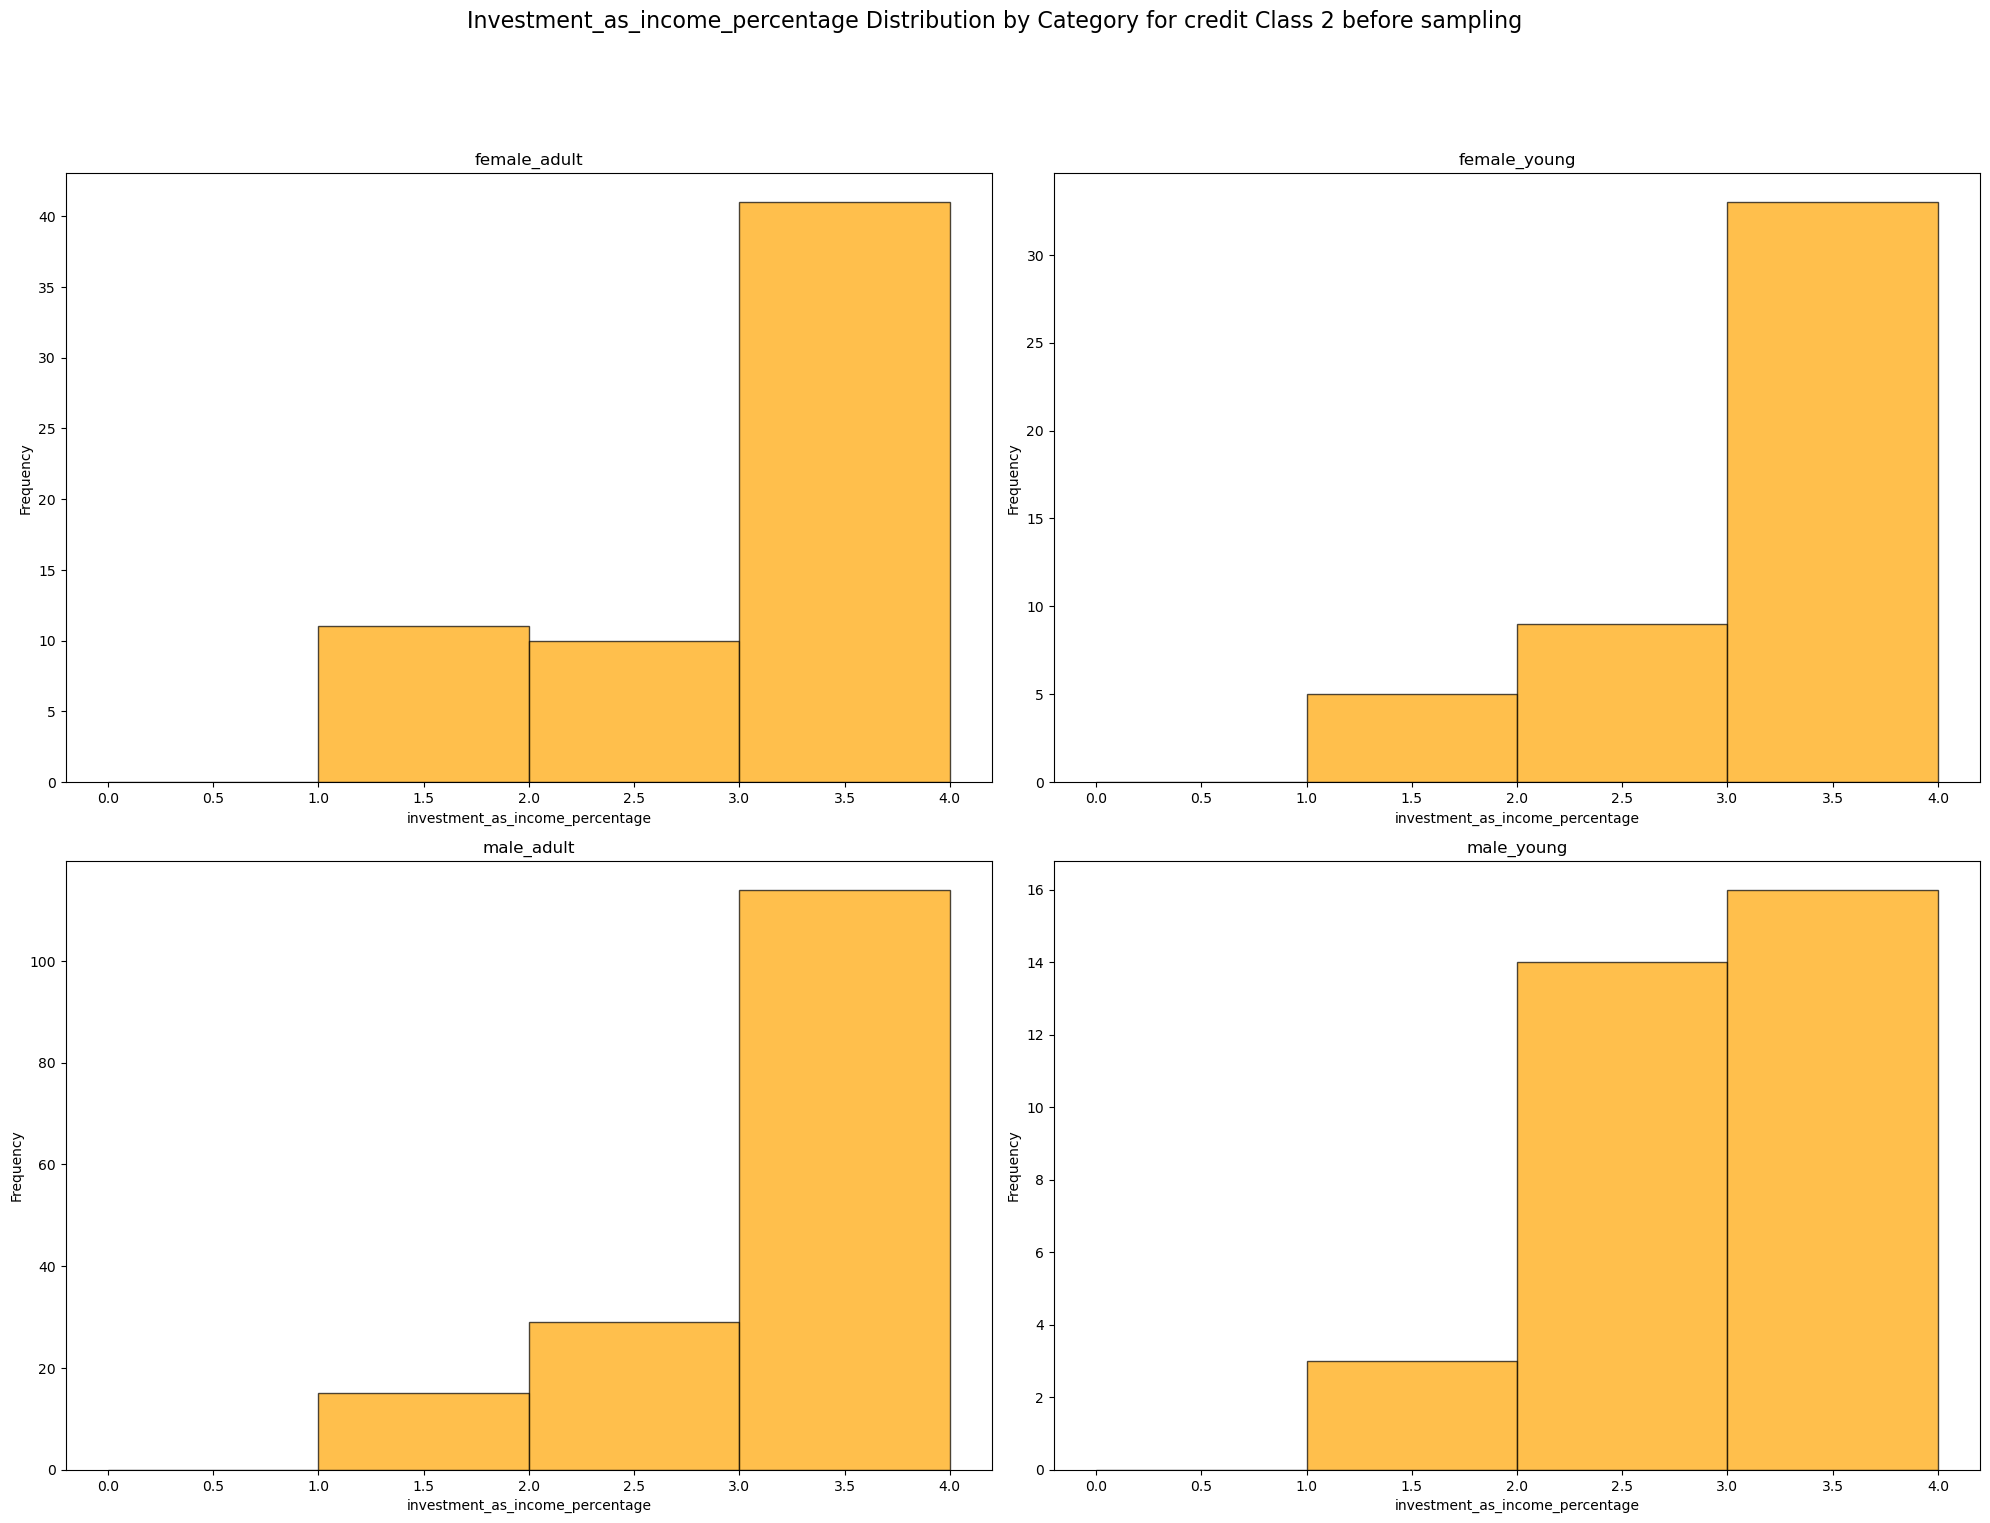

In [10]:
# Combine the categories into single strings for each row
combined_categories = data['sex'] + "_" + data['Age_Metric']

# Apply one-hot encoding to these combined categories
combined_one_hot_encoded = pd.get_dummies(combined_categories)

# Rename the columns to lowercase for consistency
combined_one_hot_encoded.columns = combined_one_hot_encoded.columns.str.lower()

# Show the first few rows of the combined one-hot encoded features to verify
combined_one_hot_encoded.head()

# Prepare the dataset with the one-hot encoded features and necessary columns for plotting
plotting_data = data[['investment_as_income_percentage', 'credit']].join(combined_one_hot_encoded)

# Set up the plotting environment
# Set up the plotting environment for Class 1A
plt.figure(figsize=(20, 30))
plt.suptitle('Investment_as_income_percentage Distribution by Category for credit Class 1 before sampling', fontsize=16)

for i, column in enumerate(combined_one_hot_encoded.columns, start=1):
    plt.subplot(4, 2, i)  # Adjust layout for 8 plots in one figure
    filtered_data_class_1 = plotting_data[(plotting_data[column] == 1) & (plotting_data['credit'] == 1)]
    plt.hist(filtered_data_class_1['investment_as_income_percentage'], bins=range(0, filtered_data_class_1['investment_as_income_percentage'].max() + 1), alpha=0.7, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('investment_as_income_percentage')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Set up the plotting environment for Class 2
plt.figure(figsize=(20, 30))
plt.suptitle('Investment_as_income_percentage Distribution by Category for credit Class 2 before sampling', fontsize=16)

for i, column in enumerate(combined_one_hot_encoded.columns, start=1):
    plt.subplot(4, 2, i)  # Adjust layout for 8 plots in one figure
    filtered_data_class_2 = plotting_data[(plotting_data[column] == 1) & (plotting_data['credit'] == 2)]
    plt.hist(filtered_data_class_2['investment_as_income_percentage'], bins=range(0, filtered_data_class_2['investment_as_income_percentage'].max() + 1), alpha=0.7, color='orange', edgecolor='black')
    plt.title(column)
    plt.xlabel('investment_as_income_percentage')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [63]:


# Placeholder feature and target columns
X = new_data.drop('credit', axis=1)  
y = new_data['credit'].replace({1: 0, 2: 1})


# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define preprocessing for numeric and categorical data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: Unde

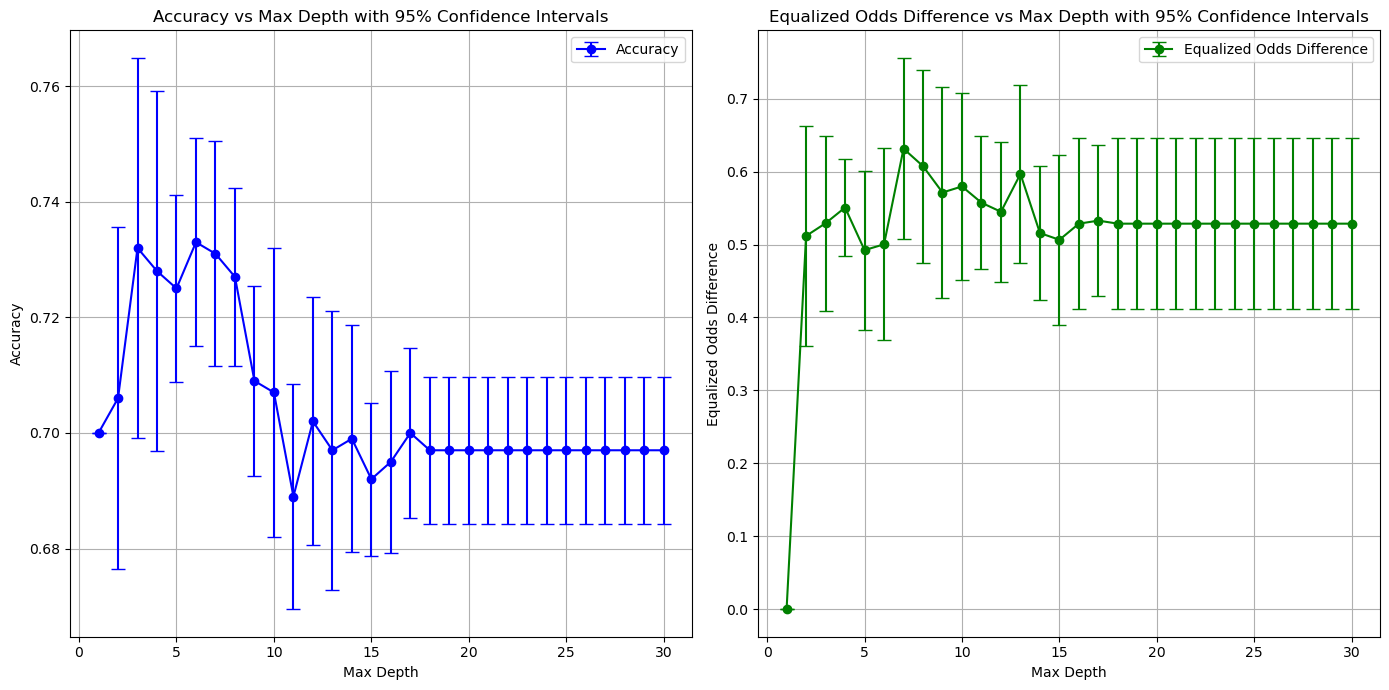

In [65]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
max_depth_range = range(1, 31)  # max_depth from 1 to 30
accuracies = {depth: [] for depth in max_depth_range}
eods = {depth: [] for depth in max_depth_range}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for depth in max_depth_range:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracies[depth].append(acc)

        # Calculate EOD
        mf = MetricFrame(metrics={'tpr': true_positive_rate, 'fpr': false_positive_rate},
                         y_true=y_test,
                         y_pred=y_pred,
                         sensitive_features=X_test[['female_adult',  'female_young',
                               'male_adult', 'male_young']])
        eod = max(mf.difference(method='between_groups')['tpr'], mf.difference(method='between_groups')['fpr'])
        eods[depth].append(eod)

# Calculate mean and confidence intervals for accuracies and eod
mean_accuracies = [np.mean(accuracies[depth]) for depth in max_depth_range]
sem_accuracies = [np.std(accuracies[depth]) / np.sqrt(len(accuracies[depth])) * 1.96 for depth in max_depth_range] 

mean_eods = [np.mean(eods[depth]) for depth in max_depth_range]
sem_eods = [np.std(eods[depth]) / np.sqrt(len(eods[depth])) * 1.96 for depth in max_depth_range]


plt.figure(figsize=(14, 7))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.errorbar(max_depth_range, mean_accuracies, yerr=sem_accuracies, label='Accuracy', fmt='-o', capsize=5, color='blue')
plt.title('Accuracy vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot for Equalized Odds Difference
plt.subplot(1, 2, 2)
plt.errorbar(max_depth_range, mean_eods, yerr=sem_eods, label='Equalized Odds Difference', fmt='-o', capsize=5, color='green')
plt.title('Equalized Odds Difference vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



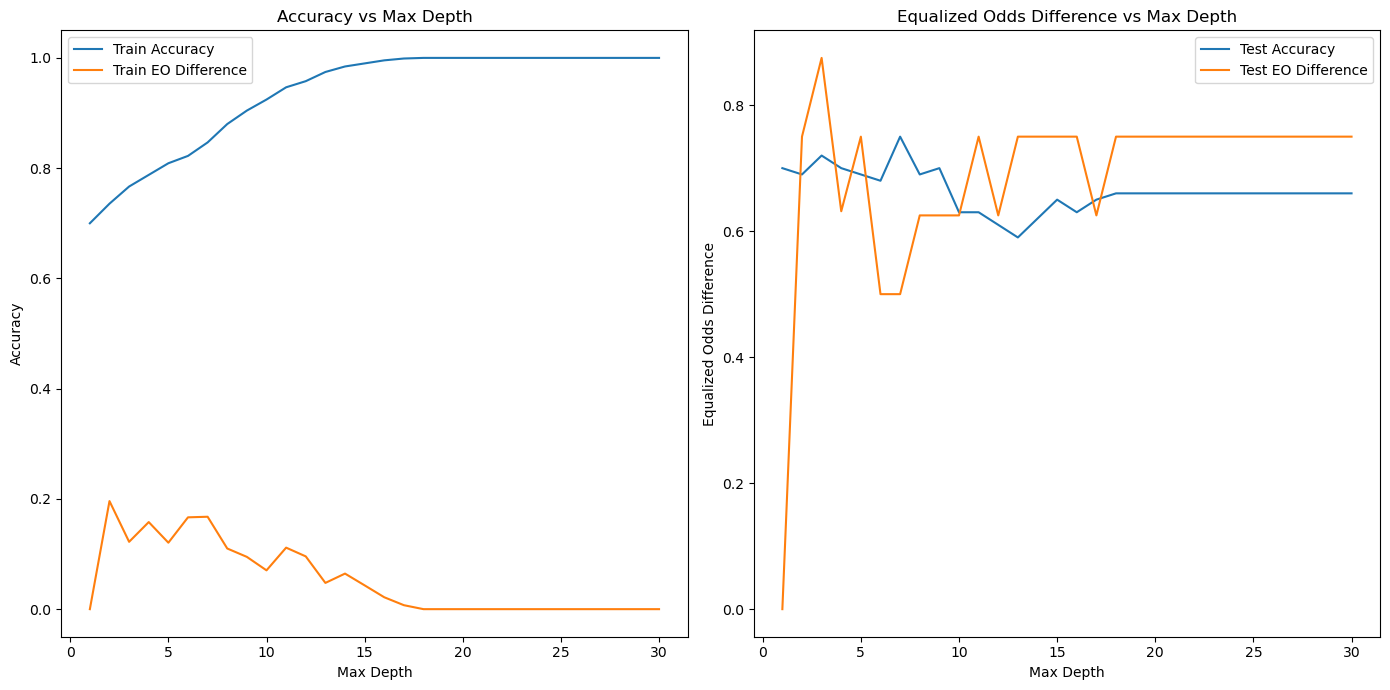

In [27]:


def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['female_adult',  'female_young',
                               'male_adult', 'male_young']]
sensitive_attr_test = X_test[['female_adult',  'female_young',
                               'male_adult', 'male_young']]

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Equalized Odds Difference vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.72


c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\olasu\anaconda5\lib\site-packages\sklearn\metrics\_classification.py:1509: Unde

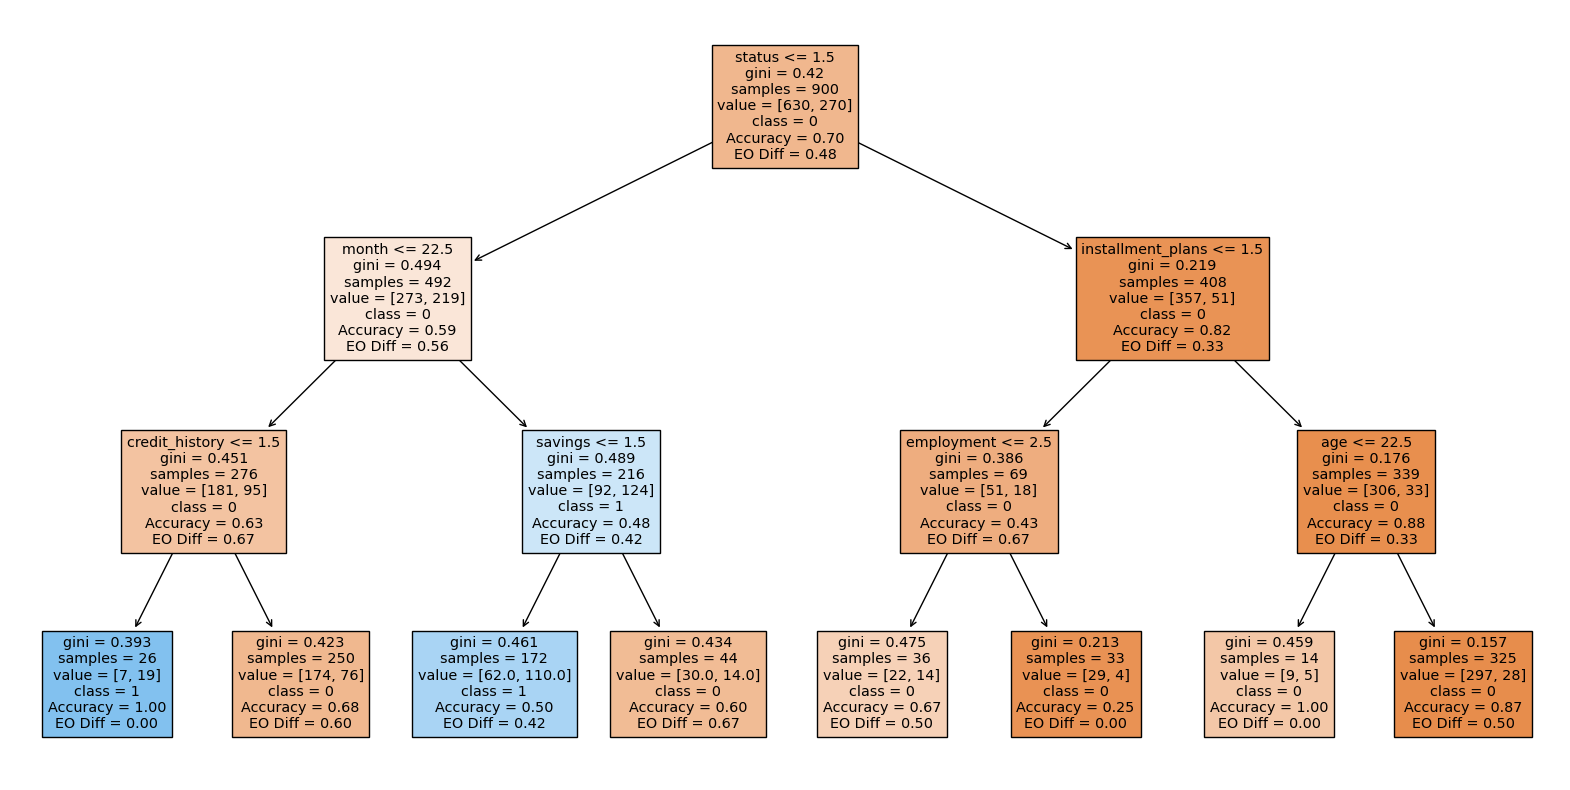

0.7666666666666667
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        70
           1       0.56      0.33      0.42        30

    accuracy                           0.72       100
   macro avg       0.66      0.61      0.62       100
weighted avg       0.70      0.72      0.70       100



In [68]:
import warnings
clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy': accuracy_score,
                
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_pred,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff


# Assuming sensitive_attr is part of your DataFrame
sensitive_attr = X_test[['female_adult',  'female_young',
                               'male_adult', 'male_young']]

node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(20, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_pred))

In [36]:
from sklearn.metrics import recall_score

sensitive_features = X_test[['female_adult',  'female_young',
                               'male_adult', 'male_young']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define the metric you want to evaluate (True Positive Rate here as an example)
def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)

# Create a MetricFrame for Equalized Odds Difference calculation using the corrected sensitive_features reference
mf_lr = MetricFrame(metrics=true_positive_rate, 
                    y_true=y_test,
                    y_pred=lr_preds,
                    sensitive_features=sensitive_feature_single)  # Use the variable directly

mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=sensitive_feature_single)  # Use the variable directly

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_single)

print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

# Additionally, you might want to look into the breakdown by group
print("\nMetric Frame for Logistic Regression:")
print(mf_lr.by_group)

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)


Equalized Odds Difference for Logistic Regression: 1.0
Equalized Odds Difference for Decision Tree: 0.875

Metric Frame for Logistic Regression:
sensitive_feature_0
female_adult    1.000000
female_young    0.000000
male_adult      0.052632
male_young      0.000000
Name: true_positive_rate, dtype: float64

Metric Frame for Decision Tree:
sensitive_feature_0
female_adult    1.000000
female_young    0.125000
male_adult      0.315789
male_young      1.000000
Name: true_positive_rate, dtype: float64


In [37]:
sensitive_features = X_test[['female_adult',  'female_young',
                               'male_adult', 'male_young']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    # Here, we ignore y_true because we're interested in the rate of positive predictions, not their correctness
    return np.mean(y_pred)

# Create a MetricFrame for Statistical Parity calculation
mf_lr_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is necessary for the MetricFrame but not used in the metric calculation
                                y_pred=lr_preds,
                                sensitive_features=sensitive_feature_single)

mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=dt_preds,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

# Additionally, to see the breakdown by group
print("\nPositive Prediction Rate by Group for Logistic Regression:")
print(mf_lr_stat_parity.by_group)

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)

Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): 0.13333333333333333
Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.07017543859649122

Positive Prediction Rate by Group for Logistic Regression:
sensitive_feature_0
female_adult    0.055556
female_young    0.133333
male_adult      0.035088
male_young      0.000000
Name: positive_prediction_rate, dtype: float64

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
female_adult    0.000000
female_young    0.066667
male_adult      0.070175
male_young      0.000000
Name: positive_prediction_rate, dtype: float64


In [65]:
# Porportional sampling

In [73]:
# Separate the dataset into two classes
data_class_1 = data[data['credit'] == 1]
data_class_2 = data[data['credit'] == 2]


# Oversample class 2
data_class_2_oversampled = resample(data_class_2,
                                    replace=True, # sample with replacement
                                    n_samples=len(data_class_1), # match number in class 1
                                    random_state=123) # reproducible results

balanced_data = pd.concat([data_class_1, data_class_2_oversampled])

# Check the new class distribution
balanced_class_distribution = balanced_data['credit'].value_counts()
balanced_class_distribution

credit
1    700
2    700
Name: count, dtype: int64

In [74]:
combined_columns_balanced = balanced_data['sex'] + "_" + balanced_data['Age_Metric'] 
one_hot_encoded_balanced = pd.get_dummies(combined_columns_balanced)


column_sums_balanced = one_hot_encoded_balanced.sum()
print(column_sums_balanced)
sampled_balanced_df = pd.DataFrame()

balanced_data.reset_index(drop=True, inplace=True)
one_hot_encoded_balanced.reset_index(drop=True, inplace=True)
balanced_data_old = pd.concat([balanced_data, one_hot_encoded_balanced], axis=1)
categorical_features = balanced_data_old.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    balanced_data_old[col] = balanced_data_old[col].fillna('missing')
    balanced_data_old[col] = le.fit_transform(balanced_data_old[col])
    
balanced_data_old = balanced_data_old.drop(['Age_Metric', 'sex'], axis = 1) 
X = balanced_data_old.drop('credit', axis=1)
y= balanced_data_old['credit'].replace({1:0, 2:1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
balanced_data_with_one_hot = pd.concat([X_train, y_train], axis=1)

target_samples = 500

# Iterate over each one-hot encoded column to sample with replacement
for column in one_hot_encoded_balanced.columns:
    # Filter rows where the category is indicated
    category_rows = balanced_data_with_one_hot[balanced_data_with_one_hot[column] == 1]
    
    # Sample with replacement from these rows to reach the target count
    sampled_rows = category_rows.sample(n=target_samples, replace=True, random_state=123)
    
    # Since we're sampling per category, each set of sampled rows will have the category set to 1 and the rest to 0
    # Reset the one-hot encoded columns to reflect only the current category
    for col in one_hot_encoded_balanced.columns:
        sampled_rows[col] = 0
    sampled_rows[column] = 1
    
    # Append the sampled rows to the new DataFrame
    sampled_balanced_df = pd.concat([sampled_balanced_df, sampled_rows])

final_sampled_counts = sampled_balanced_df[one_hot_encoded_balanced.columns].sum()

#print(sampled_balanced_df)
print(final_sampled_counts)



female_Adult    278
female_Young    182
male_Adult      824
male_Young      116
dtype: int64
female_Adult    500
female_Young    500
male_Adult      500
male_Young      500
dtype: int64


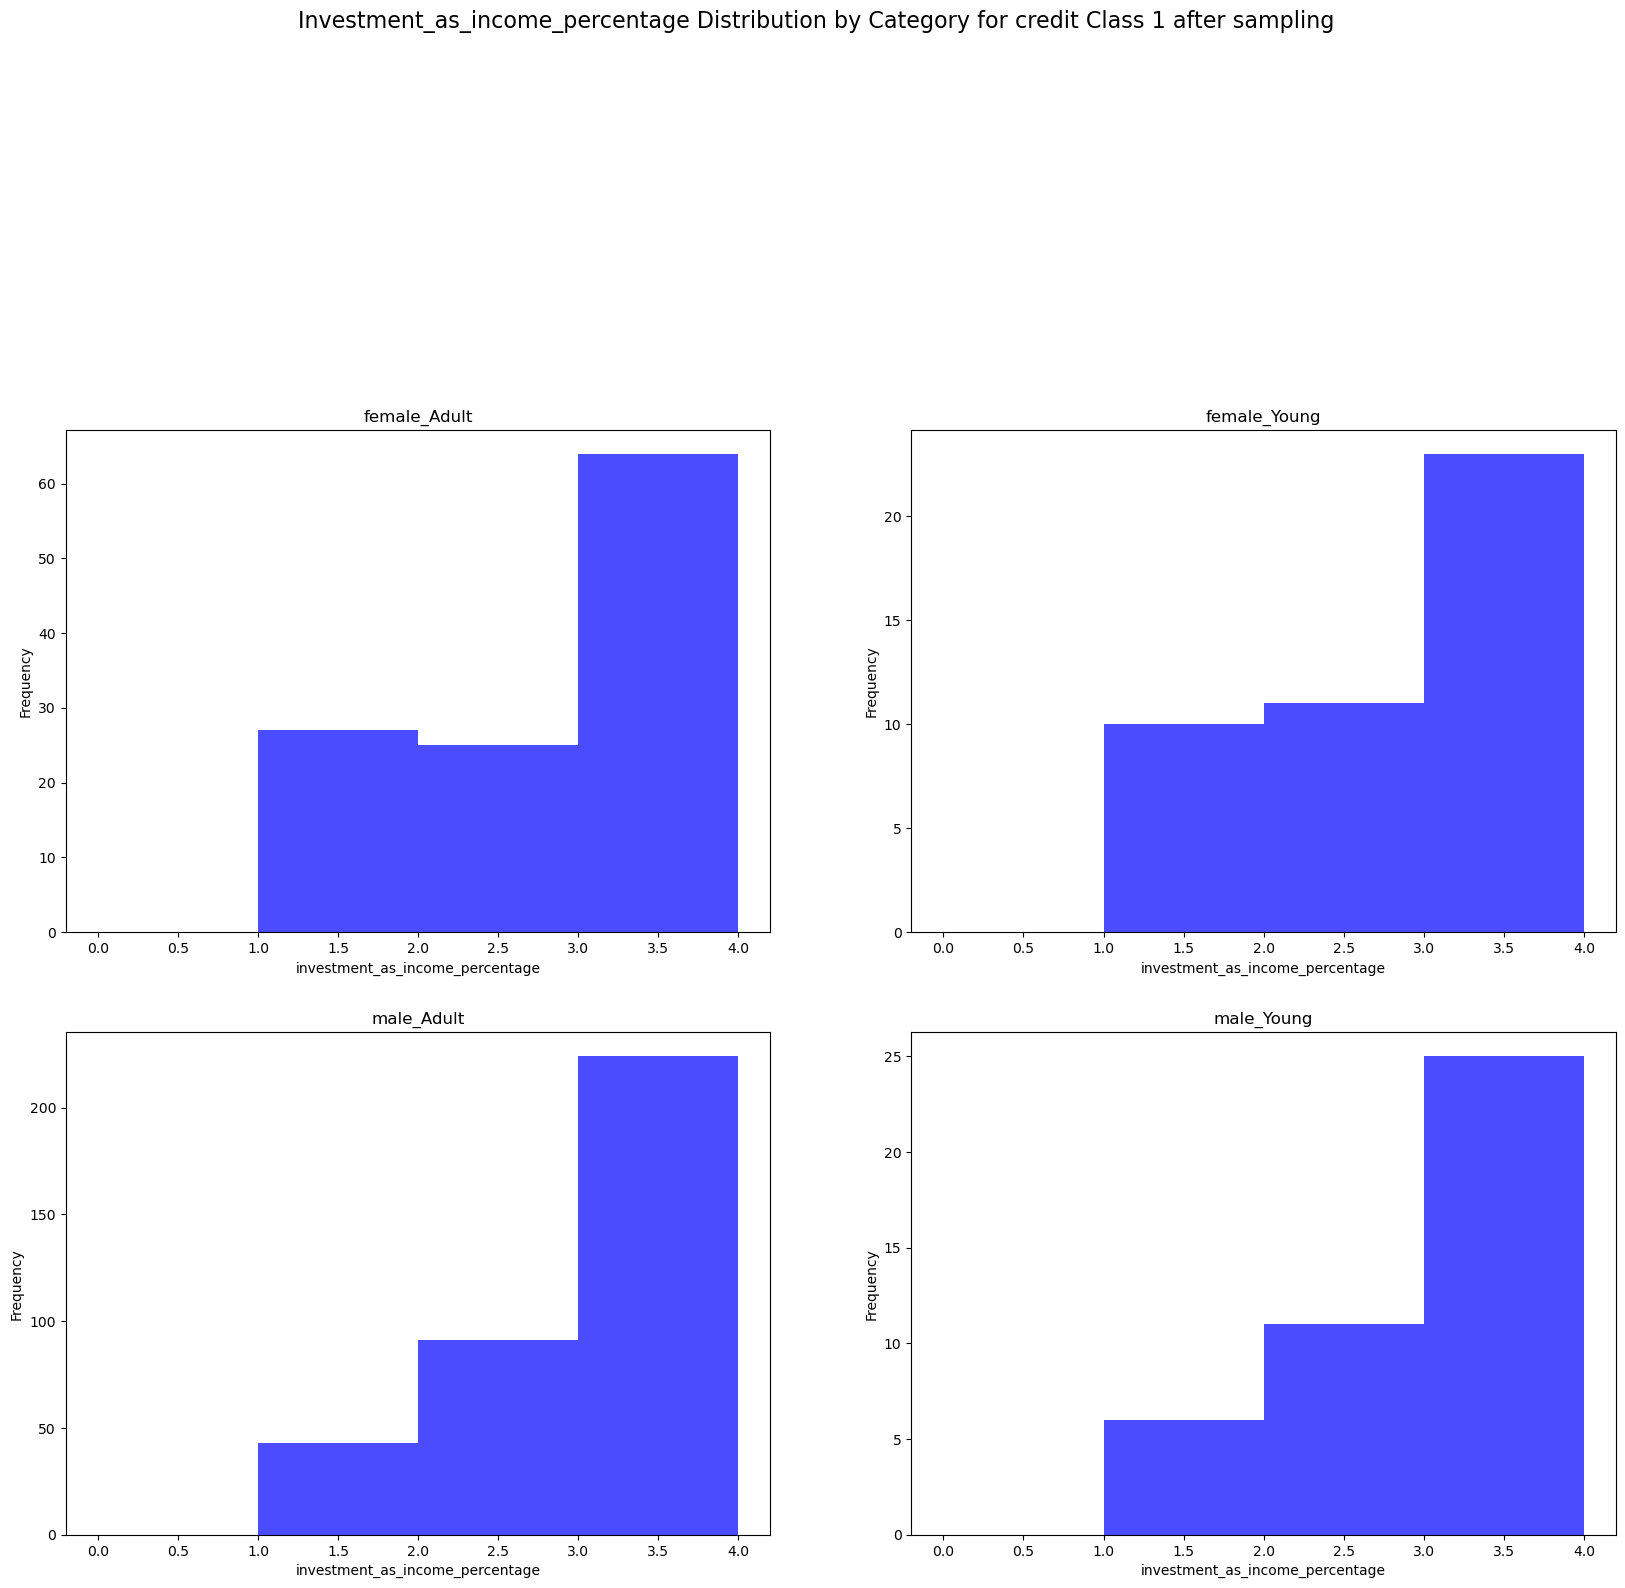

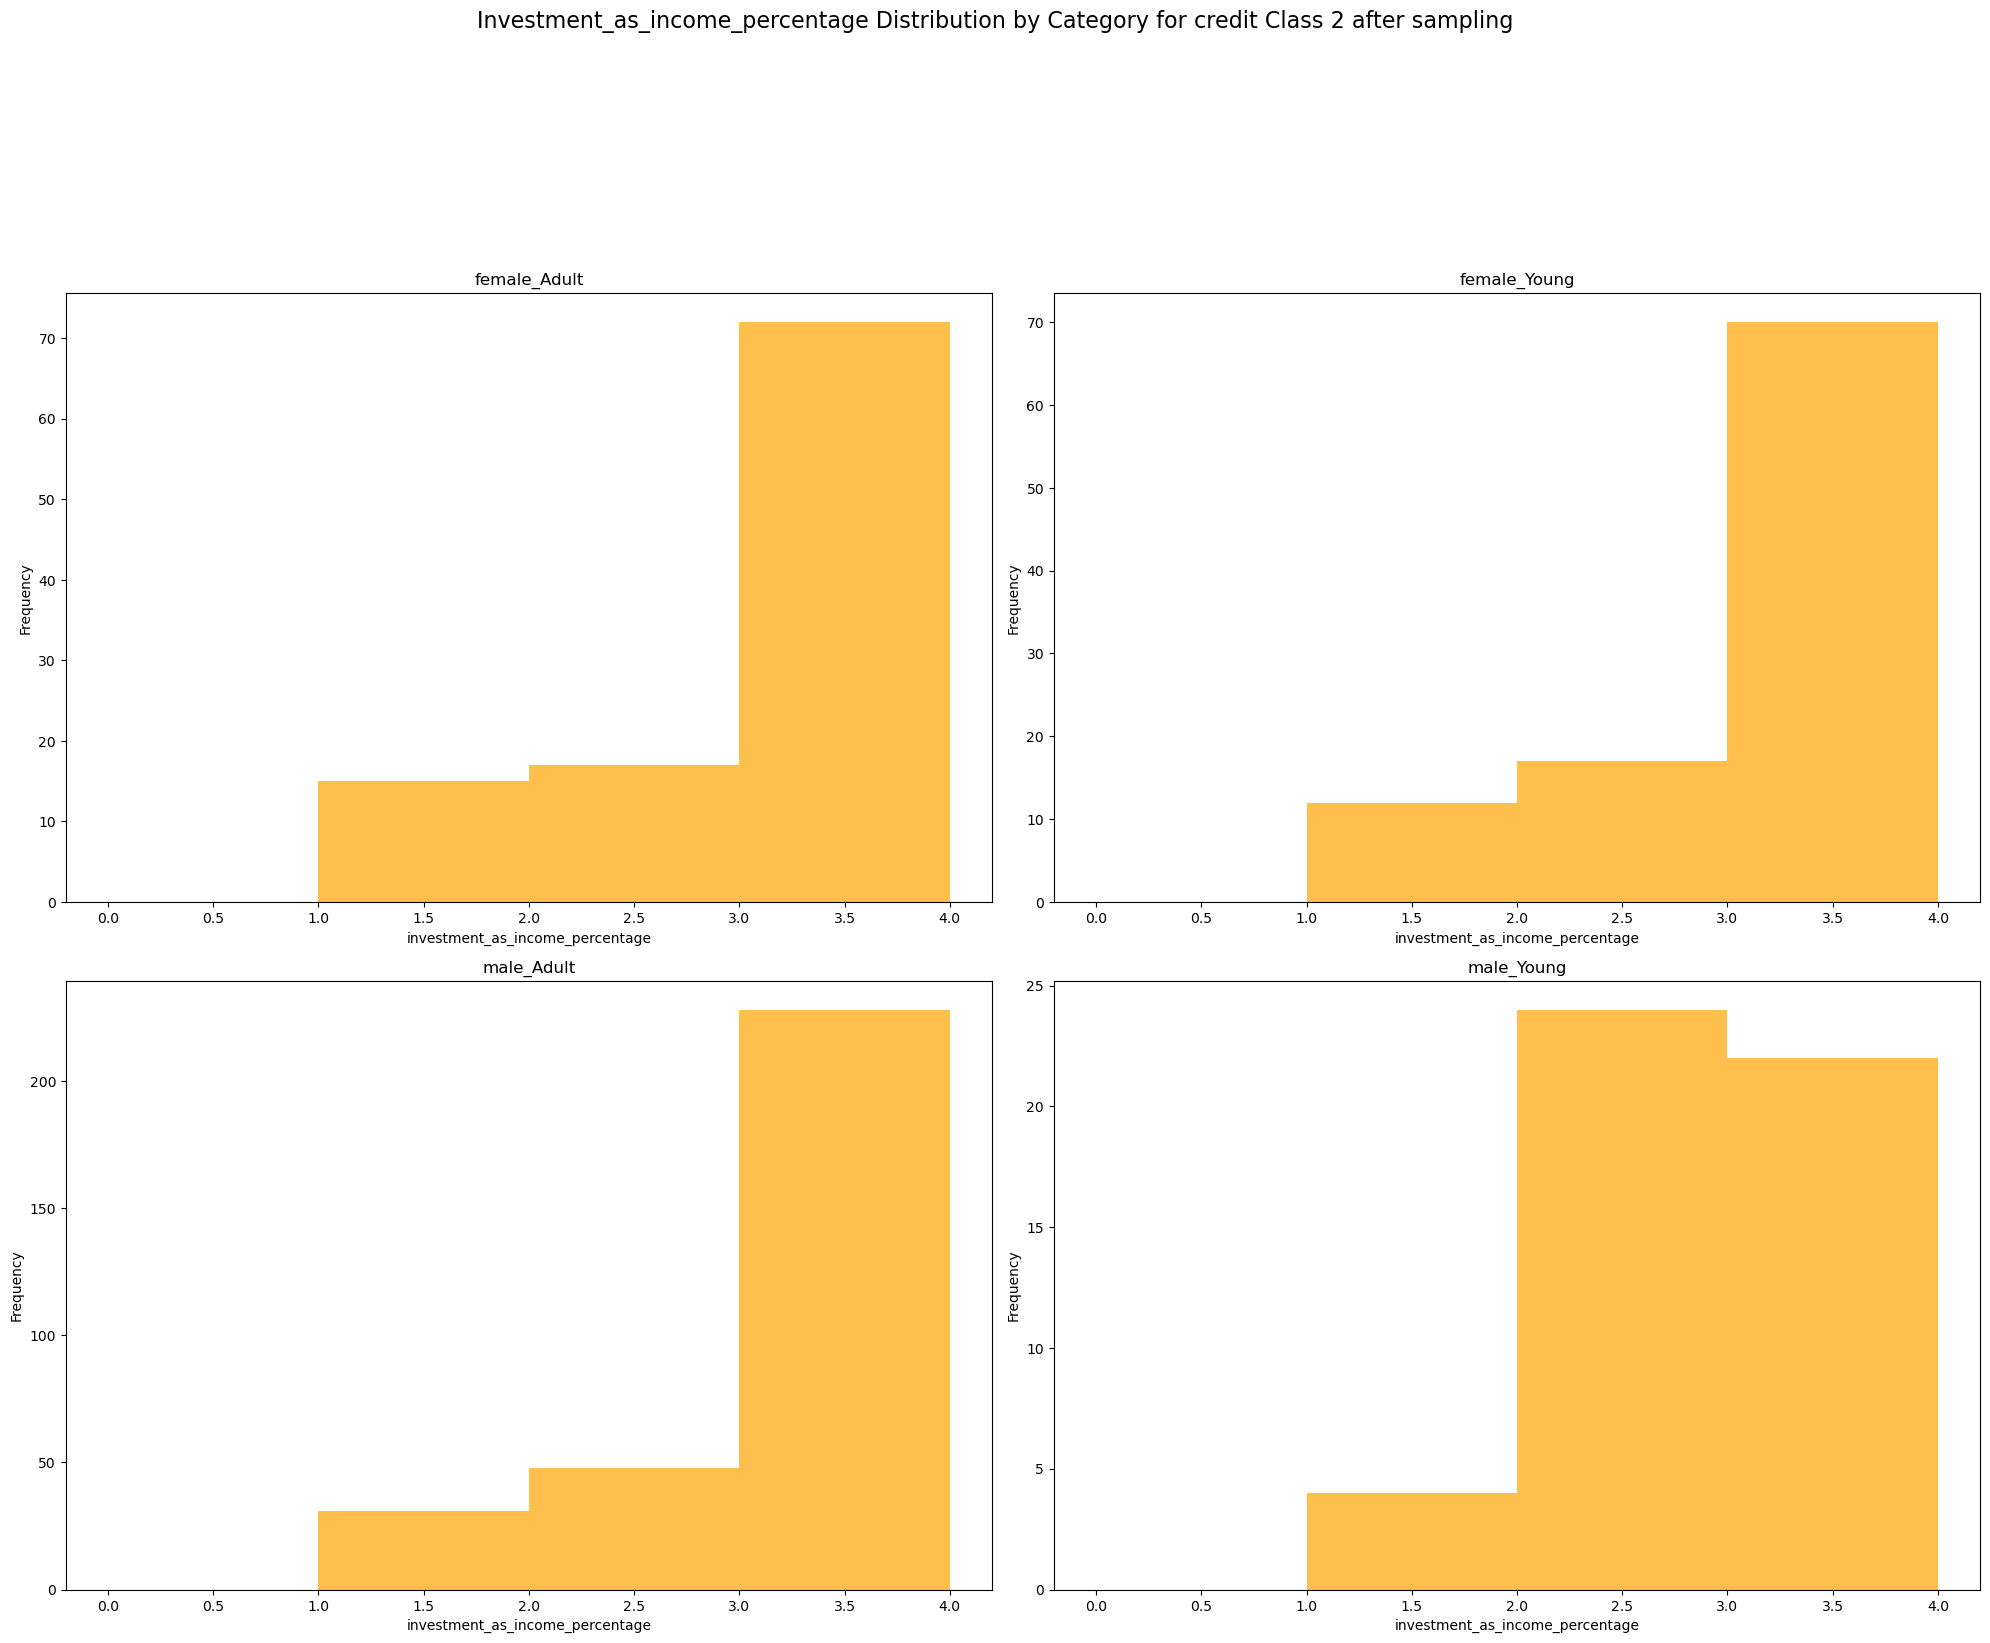

In [75]:
import matplotlib.pyplot as plt

# Define the layout for your subplots
plot_rows = 4  # Number of rows in the subplot grid
plot_cols = 2  # Number of columns in the subplot grid

# Set up the plotting environment for Class 1
plt.figure(figsize=(20, 30))
plt.suptitle('Investment_as_income_percentage Distribution by Category for credit Class 1 after sampling', fontsize=16, y=1.02)

# Plot for Class 1
for i, column in enumerate(one_hot_encoded_balanced.columns, start=1): 
    plt.subplot(plot_rows, plot_cols, i)
    # Filter data for the current category, for class 1
    category_class_1 = balanced_data_with_one_hot[(balanced_data_with_one_hot[column] == 1) & (balanced_data_with_one_hot['credit'] == 0)]
    # Plot histograms for class 1
    plt.hist(category_class_1['investment_as_income_percentage'], bins=range(0, category_class_1['investment_as_income_percentage'].max() + 1), alpha=0.7, color='blue')
    # Title and labels
    plt.title(column)
    plt.xlabel('investment_as_income_percentage')
    plt.ylabel('Frequency')

# Repeat for Class 2 in a new figure
plt.figure(figsize=(20, 30))
plt.suptitle('Investment_as_income_percentage Distribution by Category for credit Class 2 after sampling', fontsize=16, y=1.02)

# Plot for Class 2
for i, column in enumerate(one_hot_encoded_balanced.columns, start=1):  # Adjusted to include only the one-hot encoded columns
    plt.subplot(plot_rows, plot_cols, i)
    # Filter data for the current category, for class 2
    category_class_2 = balanced_data_with_one_hot[(balanced_data_with_one_hot[column] == 1) & (balanced_data_with_one_hot['credit'] == 1)]
    # Plot histograms for class 2
    plt.hist(category_class_2['investment_as_income_percentage'], bins=range(0, category_class_2['investment_as_income_percentage'].max() + 1), alpha=0.7, color='orange')
    # Title and labels
    plt.title(column)
    plt.xlabel('investment_as_income_percentage')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
#print(sampled_balanced_df)

X_train = sampled_balanced_df.drop('credit', axis = 1)
y_train = sampled_balanced_df['credit']

In [77]:
# Split the data into training and testing sets

# Define preprocessing for numeric and categorical data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object',]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Logistic Regression Pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

# Decision Tree Pipeline
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42 ))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Train the Decision Tree model
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['month', 'credit_amount', 'investment_as_income_percentage',
       'residence_since', 'age', 'number_of_credits', 'people_liable_for',
       'female_Adult', 'female_Young', 'male_Adult', 'male_Young'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [79]:
# Predictions with Logistic Regression
lr_preds = lr_pipeline.predict(X_test)
lr_probs = lr_pipeline.predict_proba(X_test)[:, 1]

# Predictions with Decision Tree
dt_preds = dt_pipeline.predict(X_test)
dt_probs = dt_pipeline.predict_proba(X_test)[:, 1]

# Accuracy scores
lr_accuracy = accuracy_score(y_test, lr_preds)
lr_auc_score = roc_auc_score(y_test, lr_probs)

dt_accuracy = accuracy_score(y_test, dt_preds)
dt_auc_score = roc_auc_score(y_test, dt_probs)


print(f'Logistic Regression Accuracy: {lr_accuracy}')
print(f'Logistic Regression AUC Score: {lr_auc_score}')
print(f'Decision Tree Accuracy: {dt_accuracy}')
print(f'Decsion Tree AUC Score: {dt_auc_score}')

Logistic Regression Accuracy: 0.6321428571428571
Logistic Regression AUC Score: 0.6732653061224491
Decision Tree Accuracy: 0.7607142857142857
Decsion Tree AUC Score: 0.7607142857142857


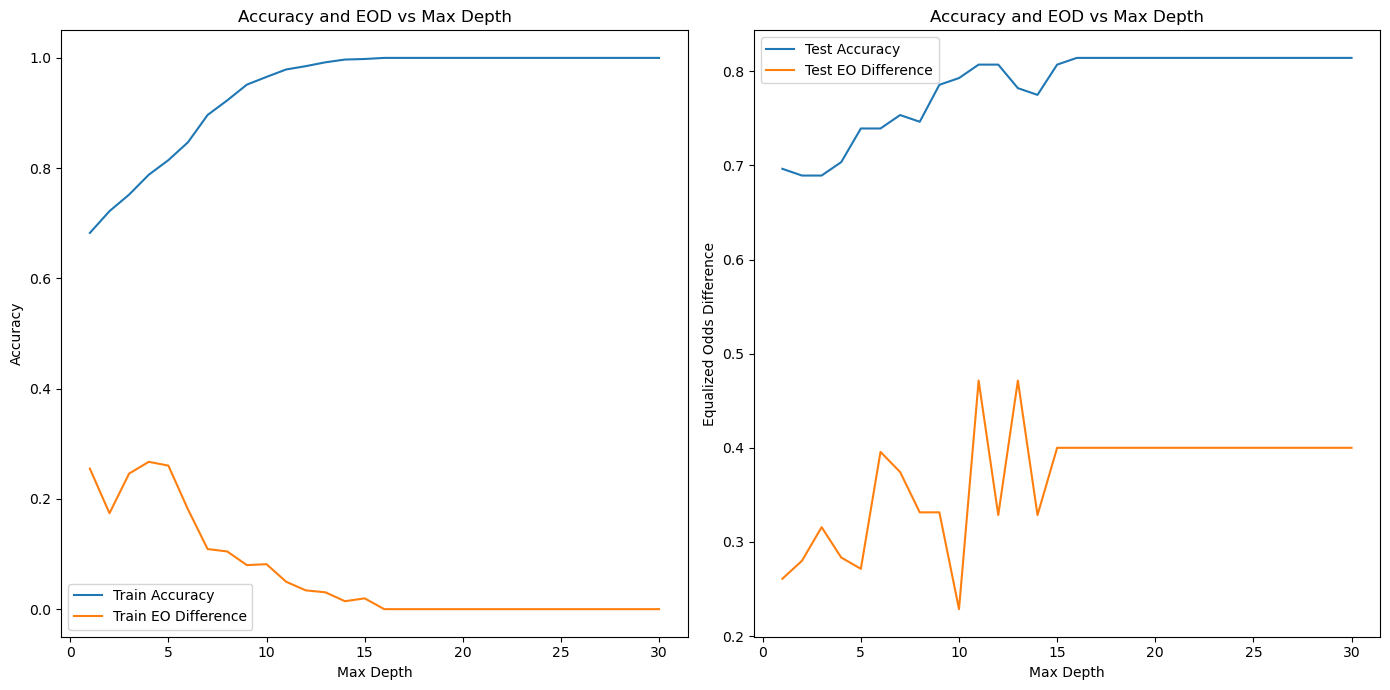

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_difference

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate,
                        'accuracy': accuracy_score
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[["female_Adult", "female_Young", "male_Adult",  "male_Young"
                             ]]
sensitive_attr_test = X_test[["female_Adult", "female_Young", "male_Adult",  "male_Young"
                             ]]

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy and EOD vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Accuracy and EOD vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.6892857142857143


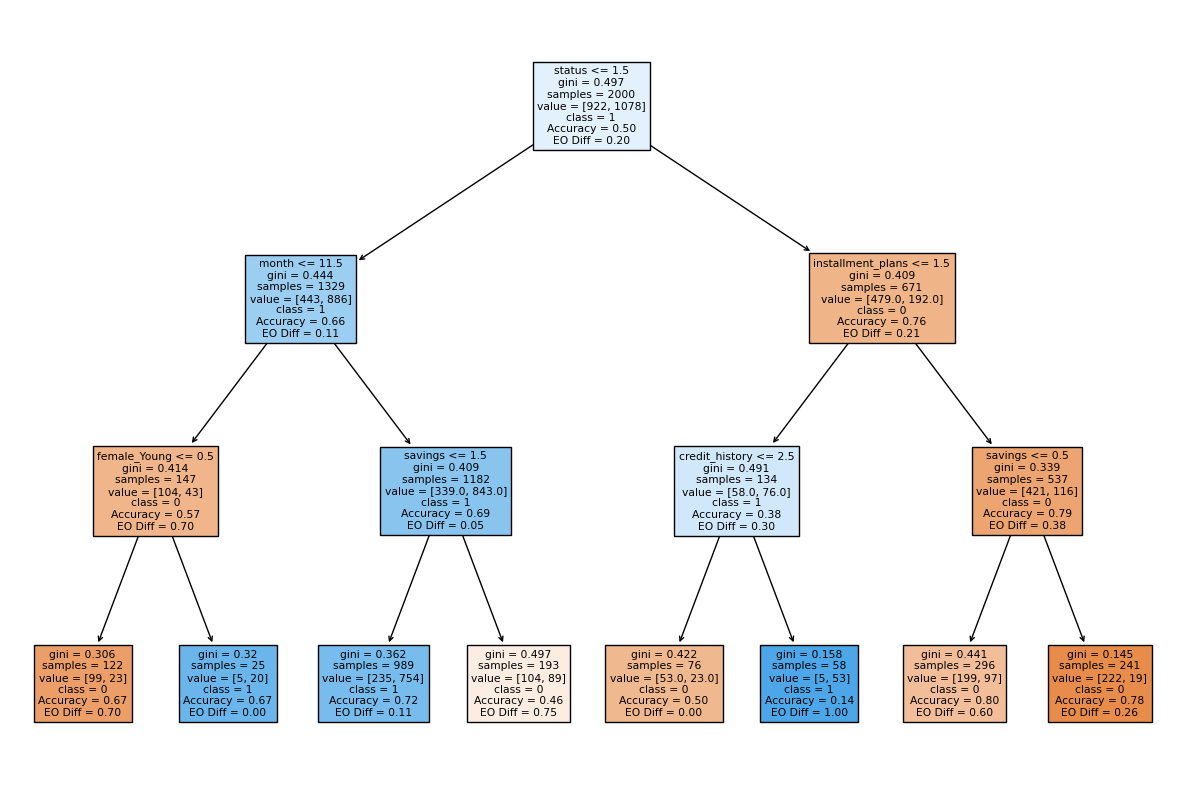

0.752
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       140
           1       0.69      0.69      0.69       140

    accuracy                           0.69       280
   macro avg       0.69      0.69      0.69       280
weighted avg       0.69      0.69      0.69       280



In [81]:

clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_predic = clf.predict(X_test)
print(accuracy_score(y_test, y_predic))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy': accuracy_score
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff


# Assuming sensitive_attr is part of your DataFrame
sensitive_attr = X_test[["female_Adult", "female_Young", "male_Adult",  "male_Young"
                             ]]
node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(15, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_predic))

In [82]:

sensitive_features = X_test[["female_Adult", "female_Young", "male_Adult",  "male_Young"
                             ]]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

metrics = {
    'accuracy': accuracy_score,
    'tpr': true_positive_rate,
    'fpr': false_positive_rate,
}

# Define the metric you want to evaluate (True Positive Rate here as an example)
def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)

# Create a MetricFrame for Equalized Odds Difference calculation using the corrected sensitive_features reference
mf_lr = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=lr_preds,
                    sensitive_features=sensitive_feature_single)  # Use the variable directly

mf_dt = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  # Use the variable directly

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_predic, sensitive_features=sensitive_feature_single)

print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

# Additionally, you might want to look into the breakdown by group
print("\nMetric Frame for Logistic Regression:")
print(mf_lr.by_group)

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)
print("Equalized odds difference for TPR:", mf_dt.difference(method='between_groups'))
#print("Equalized odds difference for FPR:", mf_dt.difference(method='between_groups'))

Equalized Odds Difference for Logistic Regression: 0.5857142857142856
Equalized Odds Difference for Decision Tree: 0.315668202764977

Metric Frame for Logistic Regression:
                     accuracy       tpr       fpr
sensitive_feature_0                              
female_Adult         0.689655  0.645161  0.259259
female_Young         0.717949  1.000000  0.785714
male_Adult           0.597484  0.414286  0.258427
male_Young           0.583333  0.642857  0.500000

Metric Frame for Decision Tree:
                     accuracy       tpr       fpr
sensitive_feature_0                              
female_Adult         0.586207  0.612903  0.444444
female_Young         0.692308  0.760000  0.428571
male_Adult           0.710692  0.642857  0.235955
male_Young           0.791667  0.928571  0.400000
Equalized odds difference for TPR: accuracy    0.205460
tpr         0.315668
fpr         0.208489
dtype: float64


In [86]:
import numpy as np

sensitive_features = X_test[["female_Adult", "female_Young", "male_Adult",  "male_Young"
                             ]]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    # Here, we ignore y_true because we're interested in the rate of positive predictions, not their correctness
    return np.mean(y_pred)

# Create a MetricFrame for Statistical Parity calculation
mf_lr_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is necessary for the MetricFrame but not used in the metric calculation
                                y_pred=lr_preds,
                                sensitive_features=sensitive_feature_single)

mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=dt_preds,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

# Additionally, to see the breakdown by group
print("\nPositive Prediction Rate by Group for Logistic Regression:")
print(mf_lr_stat_parity.by_group)

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)


Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): 0.5960328979196905
Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.16545718432510892

Positive Prediction Rate by Group for Logistic Regression:
sensitive_feature_0
female_Adult    0.465517
female_Young    0.923077
male_Adult      0.327044
male_Young      0.583333
Name: positive_prediction_rate, dtype: float64

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
female_Adult    0.620690
female_Young    0.769231
male_Adult      0.603774
male_Young      0.625000
Name: positive_prediction_rate, dtype: float64


Oversampling

In [112]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and prepare the dataset
data = pd.read_csv("C:/Users/olasu/Downloads/germandata.csv")
data['combined_category'] = data['sex'] + "_" + data['Age_Metric']
encoded_data = pd.get_dummies(data, columns=['combined_category'])
encoded_data.drop(['Age_Metric', 'sex', 'age'], axis=1, inplace=True)

# Encode other categorical features
categorical_features = encoded_data.select_dtypes(include=['object', 'bool']).columns
for col in categorical_features:
    encoded_data[col] = encoded_data[col].fillna('missing')
    encoded_data[col] = LabelEncoder().fit_transform(encoded_data[col])

X = encoded_data.drop('credit', axis=1)
y = encoded_data['credit'].replace({1: 0, 2: 1})

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the baseline proportion for a specific category
baseline_count = X_train['combined_category_male_Adult'].sum()
total_count = len(X_train)
baseline_proportion = baseline_count / total_count

# Balancing the data
balanced_data = pd.DataFrame()
categories = [col for col in X_train.columns if 'combined_category_' in col]
for category in categories:
    category_data = X_train[X_train[category] == 1]
    category_labels = y_train[category_data.index]
    category_data = pd.concat([category_data, category_labels], axis=1)
    target_count = int(total_count * baseline_proportion)
    
    if len(category_data) < target_count:
        sampled_data = category_data.sample(n=target_count, replace=True, random_state=42)
        balanced_data = pd.concat([balanced_data, sampled_data], ignore_index=True)
    else:
        balanced_data = pd.concat([balanced_data, category_data], ignore_index=True)

X_train = balanced_data.drop('credit', axis=1)
y_train = balanced_data['credit']

print("Balanced data counts:")
print(y_train.value_counts())


Balanced data counts:
credit
0    1214
1     723
Name: count, dtype: int64


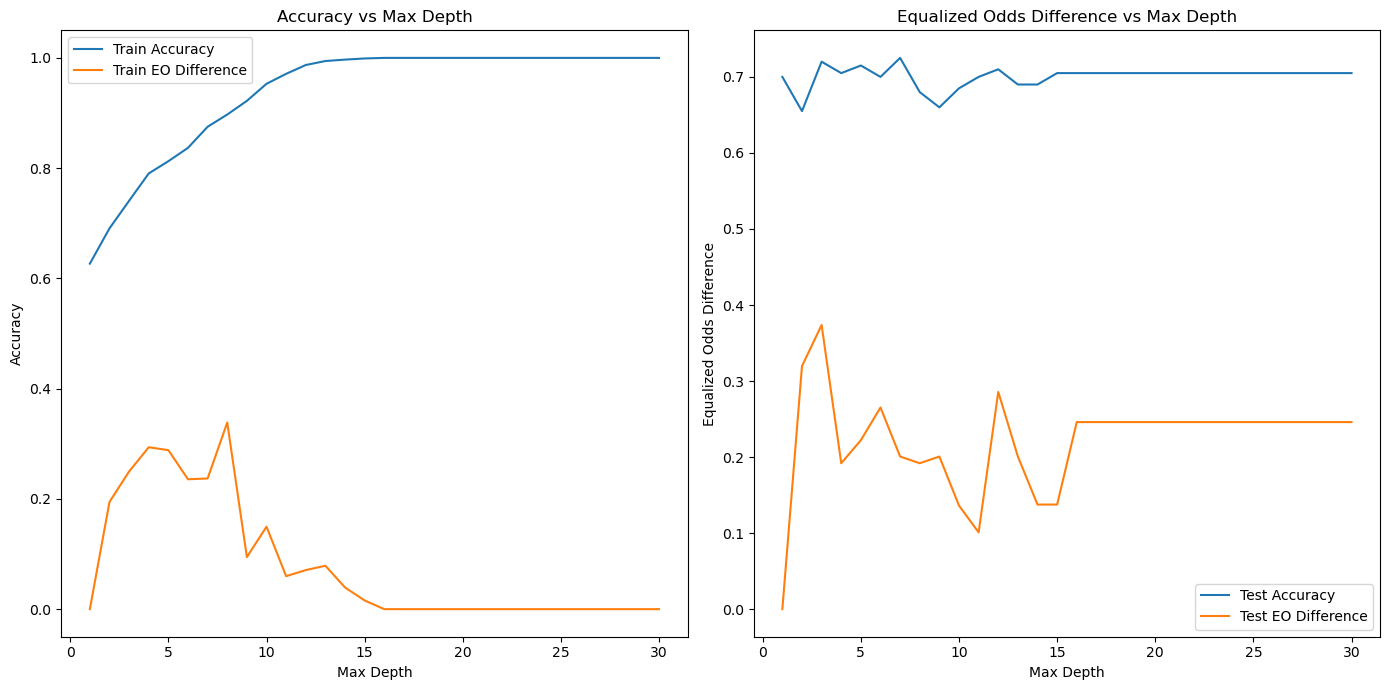

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_difference

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['combined_category_male_Adult', 'combined_category_male_Young',
'combined_category_female_Adult','combined_category_female_Young']]

sensitive_attr_test = X_test[['combined_category_male_Adult', 'combined_category_male_Young',
'combined_category_female_Adult','combined_category_female_Young']]


for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Equalized Odds Difference vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()

0.72


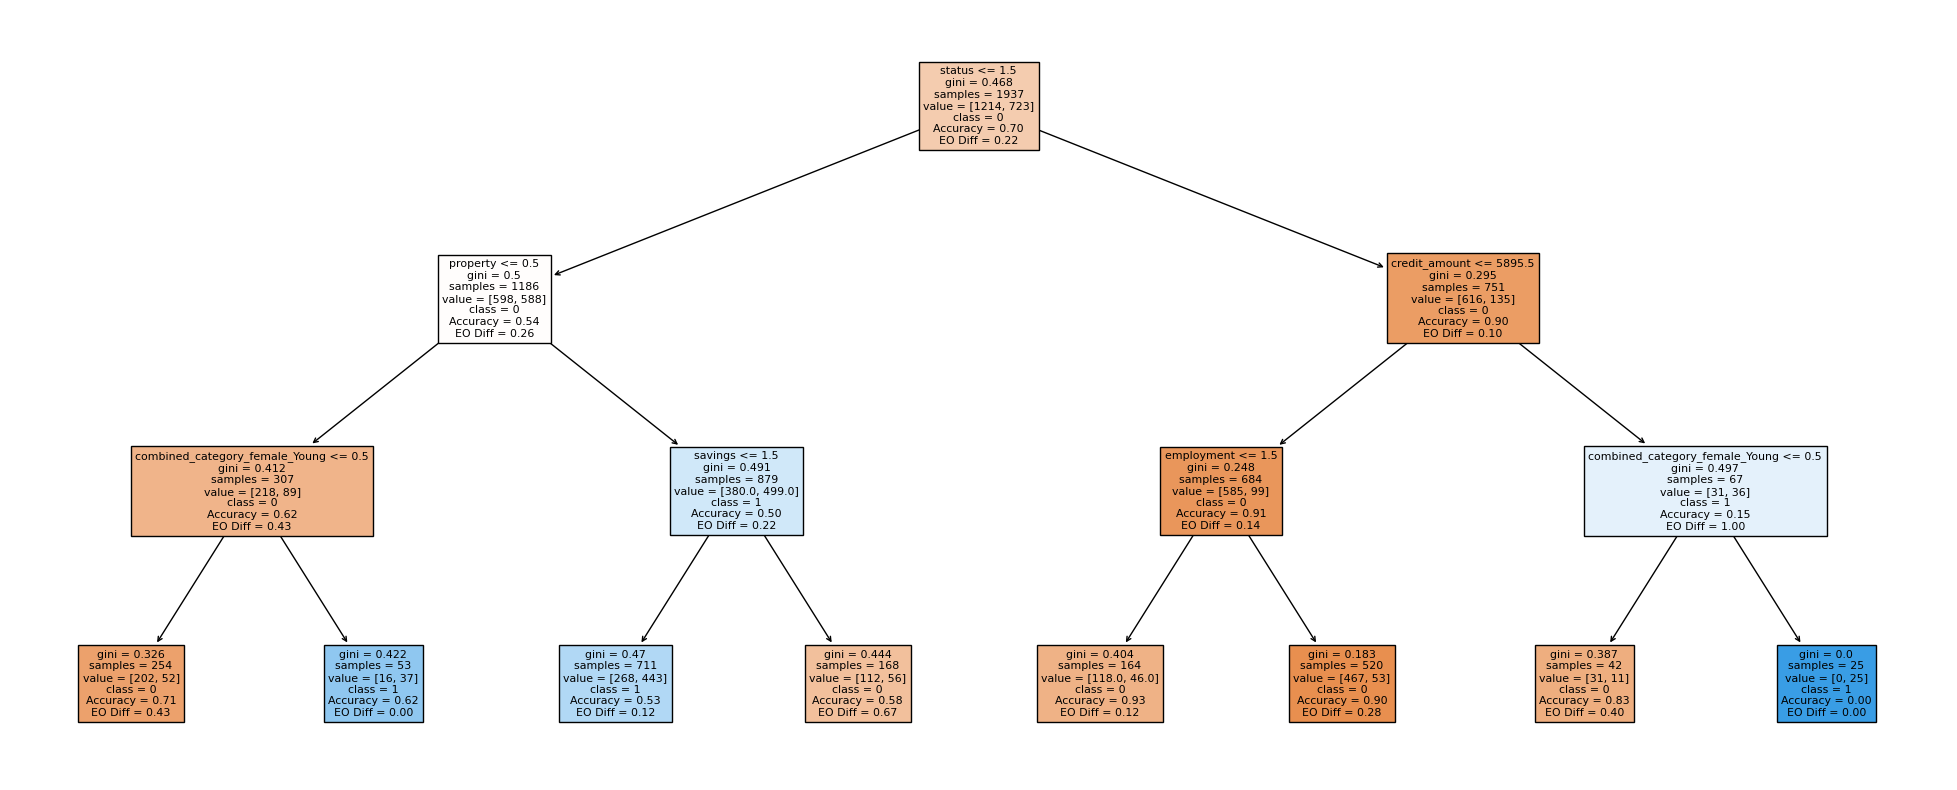

0.7408363448631905
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       140
           1       0.53      0.60      0.56        60

    accuracy                           0.72       200
   macro avg       0.67      0.69      0.68       200
weighted avg       0.73      0.72      0.72       200



In [122]:
import warnings
warnings.filterwarnings('ignore')

clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_predic = clf.predict(X_test)
print(accuracy_score(y_test, y_predic))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy_score': accuracy_score
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff



sensitive_attr = X_test[['combined_category_male_Adult', 'combined_category_male_Young',
'combined_category_female_Adult','combined_category_female_Young']]
node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(25, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_predic))

In [117]:
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from sklearn.metrics import recall_score

sensitive_features = X_test[['combined_category_male_Adult', 'combined_category_male_Young',
'combined_category_female_Adult','combined_category_female_Young']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)

mf_lr = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  


mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
#eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_predic, sensitive_features=sensitive_feature_single)

print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

# Additionally, you might want to look into the breakdown by group
print("\nMetric Frame for Logistic Regression:")
print(mf_lr.by_group)

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)

Equalized Odds Difference for Logistic Regression: 0.5857142857142856
Equalized Odds Difference for Decision Tree: 0.3737373737373738

Metric Frame for Logistic Regression:
                     accuracy       tpr       fpr
sensitive_feature_0                              
female_Adult         0.689655  0.645161  0.259259
female_Young         0.717949  1.000000  0.785714
male_Adult           0.597484  0.414286  0.258427
male_Young           0.583333  0.642857  0.500000

Metric Frame for Decision Tree:
sensitive_feature_0
combined_category_female_Adult    0.555556
combined_category_female_Young    0.818182
combined_category_male_Adult      0.580645
combined_category_male_Young      0.444444
Name: true_positive_rate, dtype: float64


In [124]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

sensitive_features = X_test[['combined_category_male_Adult', 'combined_category_male_Young',
'combined_category_female_Adult','combined_category_female_Young']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    # Here, we ignore y_true because we're interested in the rate of positive predictions, not their correctness
    return np.mean(y_pred)

# Create a MetricFrame for Statistical Parity calculation
mf_lr_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is necessary for the MetricFrame but not used in the metric calculation
                                y_pred=y_predic,
                                sensitive_features=sensitive_feature_single)

mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=y_predic,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

# Additionally, to see the breakdown by group
print("\nPositive Prediction Rate by Group for Logistic Regression:")
print(mf_lr_stat_parity.by_group)

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)

Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): 0.3566666666666667
Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.3566666666666667

Positive Prediction Rate by Group for Logistic Regression:
sensitive_feature_0
combined_category_female_Adult    0.305556
combined_category_female_Young    0.640000
combined_category_male_Adult      0.283333
combined_category_male_Young      0.368421
Name: positive_prediction_rate, dtype: float64

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
combined_category_female_Adult    0.305556
combined_category_female_Young    0.640000
combined_category_male_Adult      0.283333
combined_category_male_Young      0.368421
Name: positive_prediction_rate, dtype: float64


Custom Smote

In [128]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def custom_smote(data, n_samples):
    """
    Custom SMOTE-like function to generate synthetic samples within a single category.
    
    :param data: Data subset belonging to a specific category (numpy array).
    :param n_samples: Number of synthetic samples to generate.
    :return: Synthetic samples generated within the given category.
    """
    # Initialize the synthetic samples array
    synthetic_samples = np.zeros((n_samples, data.shape[1]))
    
    # Fit the NearestNeighbors model to the data
    nn = NearestNeighbors(n_neighbors=2).fit(data)
    neighbors = nn.kneighbors(data, return_distance=False)
    
    # Generate synthetic samples
    for i in range(n_samples):
        # Randomly choose a sample to serve as the base for the synthetic sample
        sample_idx = np.random.randint(data.shape[0])
        # Use one of its nearest neighbors
        nn_idx = np.random.choice(neighbors[sample_idx, 1:])
        
        # Calculate the difference between the sample and its neighbor
        diff = data[nn_idx] - data[sample_idx]
        # Generate a random weight to interpolate between the sample and its neighbor
        weight = np.random.rand(1)
        
        # Create the synthetic sample
        synthetic_samples[i] = data[sample_idx] + weight * diff
    
    return synthetic_samples

def generate_balanced_synthetic_labels(n_samples_needed, balance_ratio):
    """
    Generates a balanced list of class labels for synthetic samples.
    
    :param n_samples_needed: Total number of synthetic samples needed.
    :param balance_ratio: Target ratio of class 1 labels to total labels. 
                          Default is 0.5 for equal balance.
    :return: A list of synthetic labels with the specified balance.
    """
    n_class_1 = int(n_samples_needed * balance_ratio)
    n_class_0 = n_samples_needed - n_class_1  # Adjust to ensure total matches n_samples_needed
    
    synthetic_labels = [0] * n_class_0 + [1] * n_class_1
    np.random.shuffle(synthetic_labels)  # Shuffle to mix class labels
    
    return synthetic_labels


In [162]:
# Load the data
file_path = 'C:/Users/olasu/Downloads/germandata.csv'
df = pd.read_csv(file_path)

# Combine categories and create a new column for them
df['combined_category'] = df['sex'] + "_" + df['Age_Metric'] 
df['credit'] = df['credit'].replace({1: 0, 2: 1}) 

combined_one_hot_encoded = pd.get_dummies(df['combined_category'])
print(combined_one_hot_encoded)
combined_one_hot_encoded.columns = combined_one_hot_encoded.columns.str.lower()

# Join the one-hot encoded data back to the original DataFrame and drop unnecessary columns
new_data = df.join(combined_one_hot_encoded)
new_data.drop(["Age_Metric", "sex", "age"], axis=1, inplace=True)

# Encoding other categorical features
categorical_features = new_data.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    new_data[col] = new_data[col].fillna('missing')
    new_data[col] = le.fit_transform(new_data[col])

X = new_data.drop(['credit'], axis=1)
y = new_data['credit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

new_data3= pd.concat([X_train, y_train], axis=1)
categories = new_data3['combined_category'].unique()
max_size = new_data3['combined_category'].value_counts().max()
balanced_df_list = []


for category in categories:
    category_subset = new_data3[new_data3['combined_category'] == category]
    features = category_subset.drop(['credit', 'combined_category'], axis=1)
    n_samples_needed = max_size - category_subset.shape[0]
    
    if n_samples_needed > 0:
        synthetic_features = custom_smote(features.to_numpy(), n_samples_needed)
        synthetic_features_df = pd.DataFrame(synthetic_features, columns=features.columns)
        
        # Generate a balanced distribution of synthetic labels
        synthetic_labels = generate_balanced_synthetic_labels(n_samples_needed, balance_ratio=0.34)
        
        synthetic_features_df['credit'] = synthetic_labels
        synthetic_features_df['combined_category'] = category
        
        category_subset_balanced = pd.concat([category_subset, synthetic_features_df])
    else:
        category_subset_balanced = category_subset
    
    balanced_df_list.append(category_subset_balanced)

balanced_df1 = pd.concat(balanced_df_list).reset_index(drop=True)


# Prepare features and target variable
X_train = balanced_df1.drop(['credit', 'combined_category'], axis=1)  
y_train =balanced_df1['credit'] 


X_test = X_test.drop(['combined_category'], axis=1)


     female_Adult  female_Young  male_Adult  male_Young
0           False         False        True       False
1           False          True       False       False
2           False         False        True       False
3           False         False        True       False
4           False         False        True       False
..            ...           ...         ...         ...
995          True         False       False       False
996         False         False        True       False
997         False         False        True       False
998         False         False       False        True
999         False         False        True       False

[1000 rows x 4 columns]
Index(['status', 'month', 'credit_history', 'purpose', 'credit_amount',
       'savings', 'employment', 'investment_as_income_percentage',
       'other_debtors', 'residence_since', 'property', 'installment_plans',
       'housing', 'number_of_credits', 'skill_level', 'people_liable_for',
       'telep

In [166]:

max_depth_range = range(1, 31)
accuracies = {depth: [] for depth in max_depth_range}
eods = {depth: [] for depth in max_depth_range}

# Example dataset preparation
X = new_data.drop(['credit'], axis=1)
y = new_data['credit']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    new_data3= pd.concat([X_train, y_train], axis=1)
    categories = new_data3['combined_category'].unique()
    max_size = new_data3['combined_category'].value_counts().max()
   
    balanced_df_list = []


    for category in categories:
        category_subset = new_data3[new_data3['combined_category'] == category]
        features = category_subset.drop(['credit', 'combined_category'], axis=1)
        n_samples_needed = max_size - category_subset.shape[0]

        if n_samples_needed > 0:

            synthetic_features = custom_smote(features.to_numpy(),  n_samples_needed)
            synthetic_features_df = pd.DataFrame(synthetic_features, columns=features.columns)
            synthetic_labels = generate_balanced_synthetic_labels(n_samples_needed, balance_ratio=0.34)
            synthetic_features_df['credit'] = synthetic_labels
            synthetic_features_df['combined_category'] = category
            category_subset_balanced = pd.concat([category_subset, synthetic_features_df])
        else:
            category_subset_balanced = category_subset
        balanced_df_list.append(category_subset_balanced)
    balanced_df1 = pd.concat(balanced_df_list).reset_index(drop=True)
    X_train = balanced_df1.drop(['credit', 'combined_category'], axis=1)  
    y_train =balanced_df1['credit'] 
    
    X_test = X_test.drop(['combined_category'], axis=1)


    for depth in max_depth_range:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate and store accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracies[depth].append(acc)

        # Calculate and store EOD
        sensitive_features_test = X_test[[ 'female_adult', 'female_young',
       'male_adult', 'male_young']]
        mf = MetricFrame(metrics={'tpr': true_positive_rate, 'fpr': false_positive_rate},
                         y_true=y_test,
                         y_pred=y_pred,
                         sensitive_features=sensitive_features_test)
        eod = max(mf.difference(method='between_groups')['tpr'], mf.difference(method='between_groups')['fpr'])
        eods[depth].append(eod)

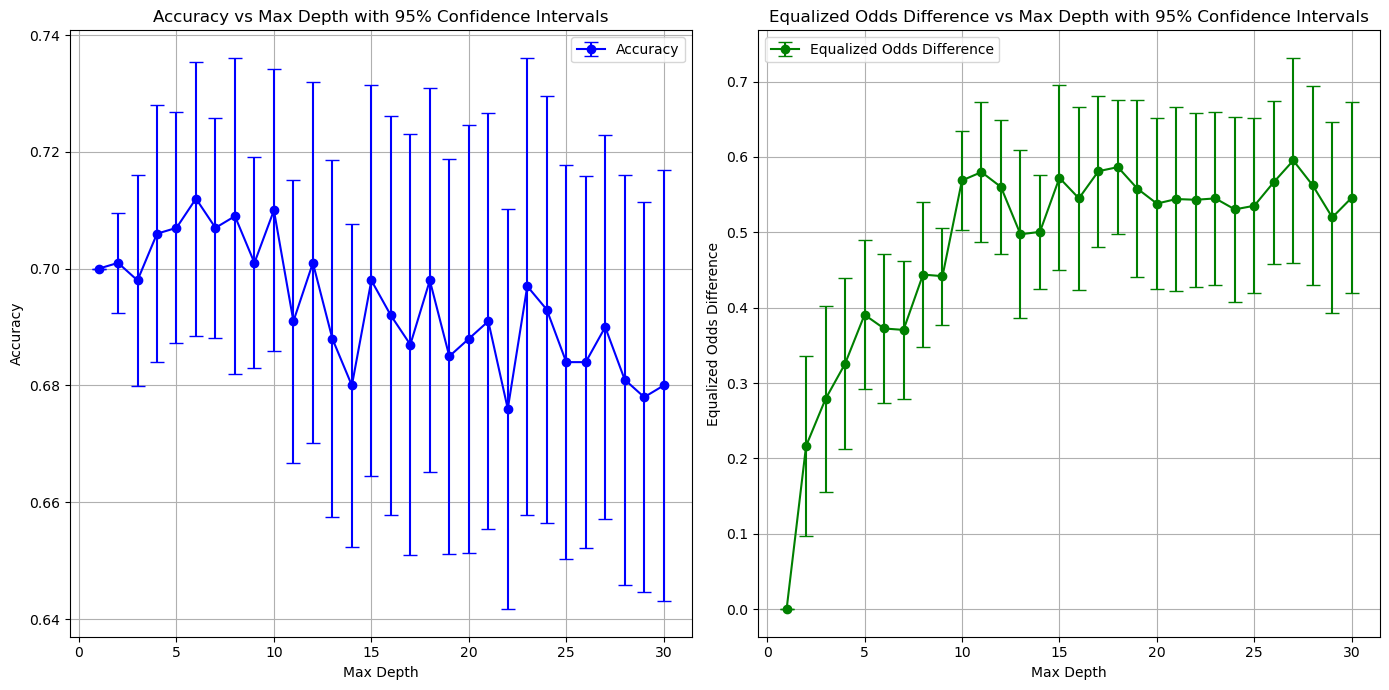

In [167]:
# Calculate mean and confidence intervals for accuracies and eod
mean_accuracies = [np.mean(accuracies[depth]) for depth in max_depth_range]
sem_accuracies = [np.std(accuracies[depth]) / np.sqrt(len(accuracies[depth])) * 1.96 for depth in max_depth_range] 

mean_eods = [np.mean(eods[depth]) for depth in max_depth_range]
sem_eods = [np.std(eods[depth]) / np.sqrt(len(eods[depth])) * 1.96 for depth in max_depth_range]


plt.figure(figsize=(14, 7))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.errorbar(max_depth_range, mean_accuracies, yerr=sem_accuracies, label='Accuracy', fmt='-o', capsize=5, color='blue')
plt.title('Accuracy vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot for Equalized Odds Difference
plt.subplot(1, 2, 2)
plt.errorbar(max_depth_range, mean_eods, yerr=sem_eods, label='Equalized Odds Difference', fmt='-o', capsize=5, color='green')
plt.title('Equalized Odds Difference vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


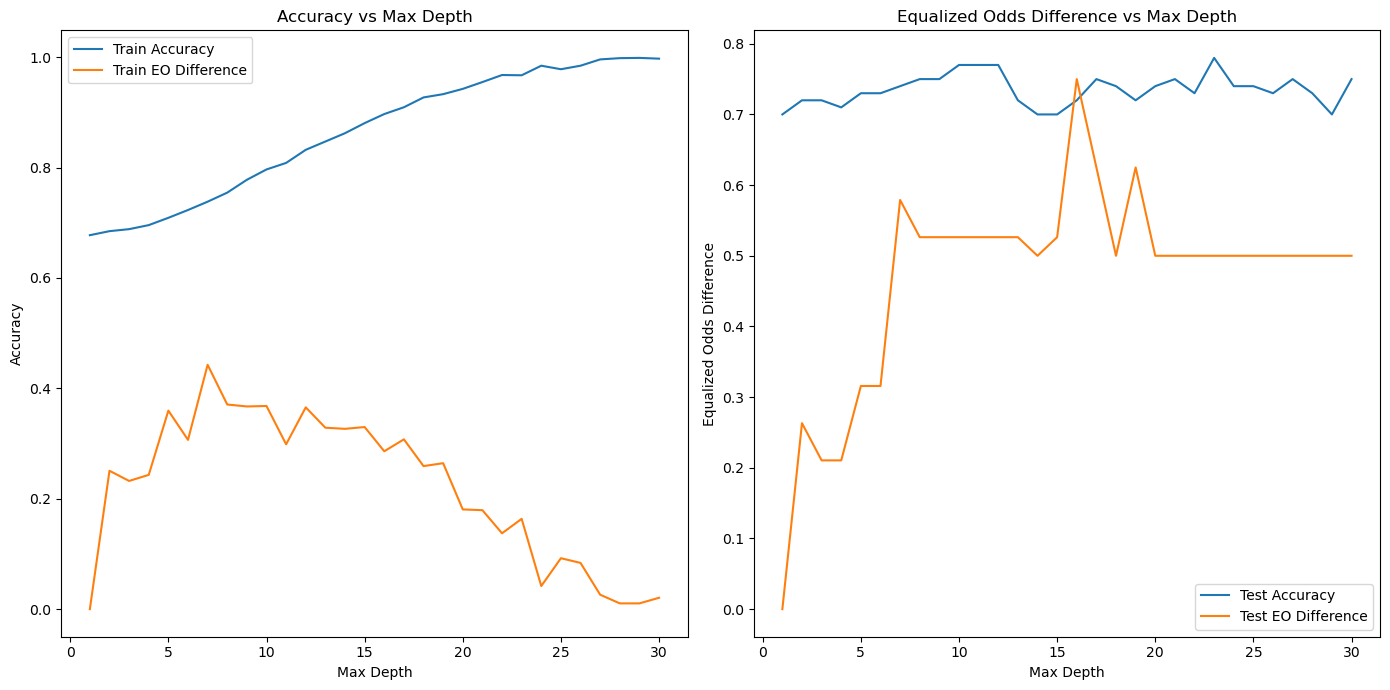

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_difference

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['female_adult', 'female_young',
                                    'male_adult', 'male_young']]

sensitive_attr_test = X_test[['female_adult', 'female_young',
                                   'male_adult', 'male_young']]


for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Equalized Odds Difference vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.72


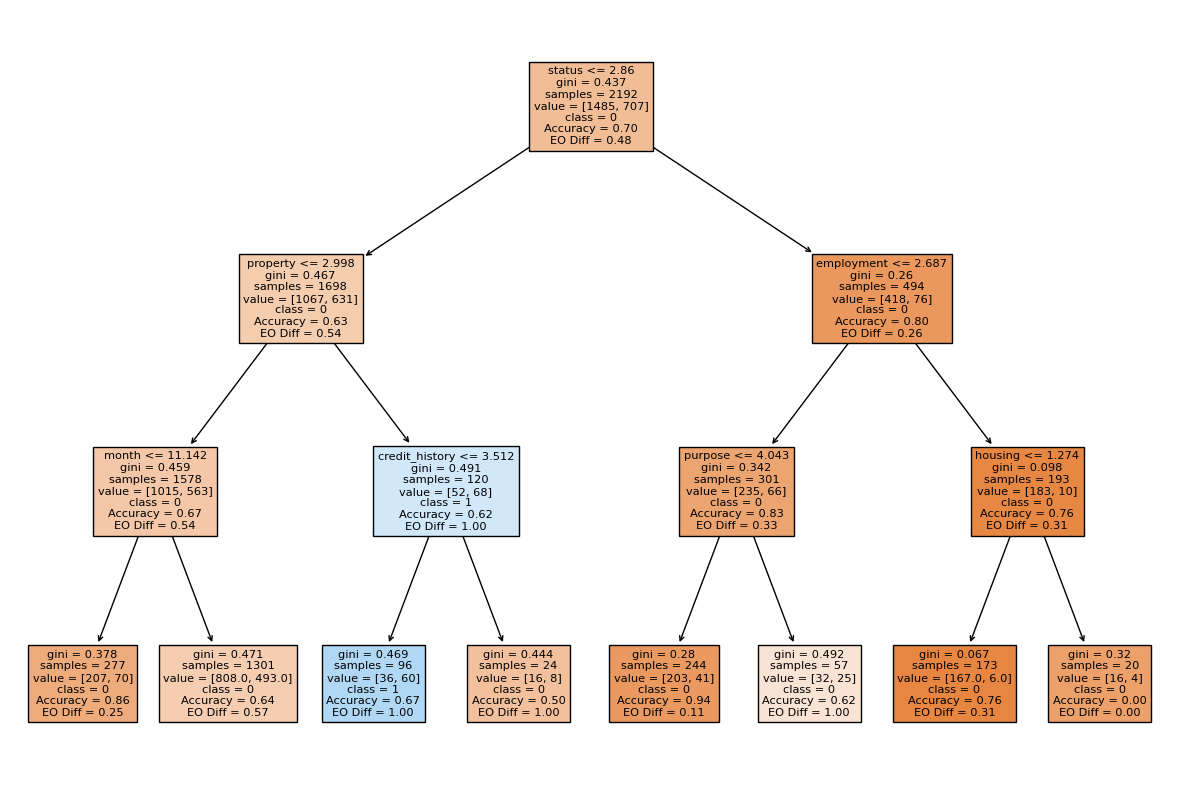

0.6884124087591241
              precision    recall  f1-score   support

           0       0.72      0.97      0.83        70
           1       0.67      0.13      0.22        30

    accuracy                           0.72       100
   macro avg       0.70      0.55      0.53       100
weighted avg       0.71      0.72      0.65       100



In [169]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_predic = clf.predict(X_test)
print(accuracy_score(y_test, y_predic))

from sklearn.metrics import recall_score, roc_auc_score

from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy': accuracy_score
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                     # sensitive_features=sensitive_attr)
    return accuracies, eo_diff




# Assuming sensitive_attr is part of your DataFrame
sensitive_attr = X_test[['female_adult', 'female_young',
                                   'male_adult', 'male_young']]
#sensitive_attr = sensitive_attr.idxmax(axis=1)
node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(15, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_predic))

In [173]:
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from sklearn.metrics import recall_score
import warnings

sensitive_features = X_test[['female_adult', 'female_young',
                                   'male_adult', 'male_young']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

def true_postive_rate(y_test, y_pred):
    return recall_score(y_test, y_pred)

mf_lr = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=lr_preds,
                    sensitive_features=sensitive_feature_single)

mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
#eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_predic, sensitive_features=sensitive_feature_single)

print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

# Additionally, you might want to look into the breakdown by group
print("\nMetric Frame for Logistic Regression:")
print(mf_lr.by_group)

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)

Equalized Odds Difference for Logistic Regression: 0.5857142857142856
Equalized Odds Difference for Decision Tree: 0.21052631578947367

Metric Frame for Logistic Regression:
                     accuracy       tpr       fpr
sensitive_feature_0                              
female_Adult         0.689655  0.645161  0.259259
female_Young         0.717949  1.000000  0.785714
male_Adult           0.597484  0.414286  0.258427
male_Young           0.583333  0.642857  0.500000

Metric Frame for Decision Tree:
sensitive_feature_0
female_adult    0.000000
female_young    0.000000
male_adult      0.210526
male_young      0.000000
Name: true_positive_rate, dtype: float64


In [177]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

sensitive_features = X_test[['female_adult', 'female_young',
                                   'male_adult', 'male_young']]

sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    # Here, we ignore y_true because we're interested in the rate of positive predictions, not their correctness
    return np.mean(y_pred)



mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=y_predic,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
#diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

# Additionally, to see the breakdown by group
print("\nPositive Prediction Rate by Group for Logistic Regression:")
print(mf_lr_stat_parity.by_group)

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)

Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): 0.3566666666666667
Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.1

Positive Prediction Rate by Group for Logistic Regression:
sensitive_feature_0
combined_category_female_Adult    0.305556
combined_category_female_Young    0.640000
combined_category_male_Adult      0.283333
combined_category_male_Young      0.368421
Name: positive_prediction_rate, dtype: float64

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
female_adult    0.000000
female_young    0.000000
male_adult      0.087719
male_young      0.100000
Name: positive_prediction_rate, dtype: float64
